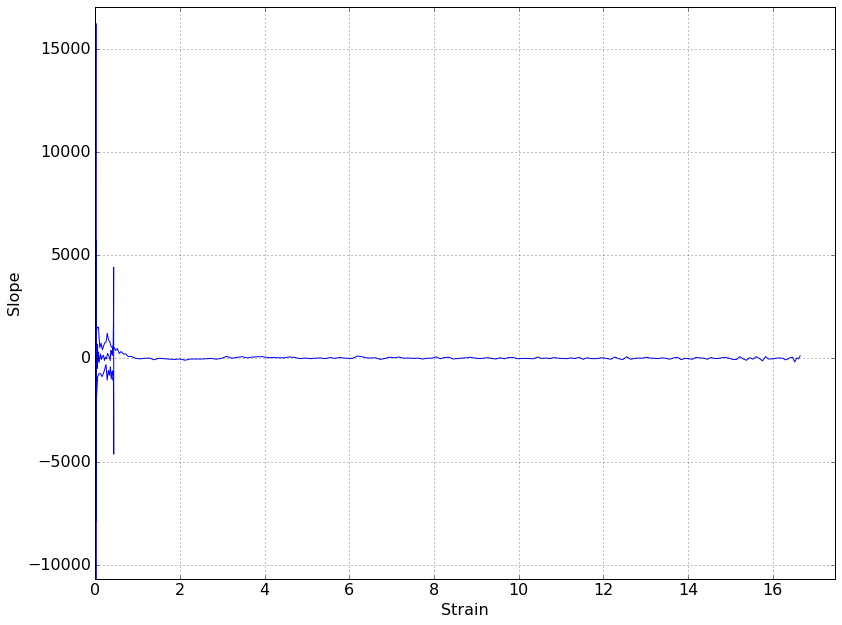

In [2]:
%load_ext autoreload
%autoreload 2  """Reloads all functions automatically"""
%matplotlib inline

from irreversible_stressstrain import StressStrain as strainmodel
import test_suite as suite
import graph_suite as plot
import numpy as np

model = strainmodel('ref/HSRS/22').get_experimental_data()

strain = model[:,0]
stress = model[:,1]

slopes = []

"""Approximating the partial derivatives of stress/strain"""
for index in xrange(len(stress)-1):
    slopes.append((stress[index+1]-stress[index])/(strain[index+1]-strain[index]))
    
"""Now what if we have strain vs slope"""
strainvslope = suite.combine_data(strain,slopes)
plot.plot2D(strainvslope,'Strain','Slope')

## It seems that based on these results it should be easy to cluster the data points

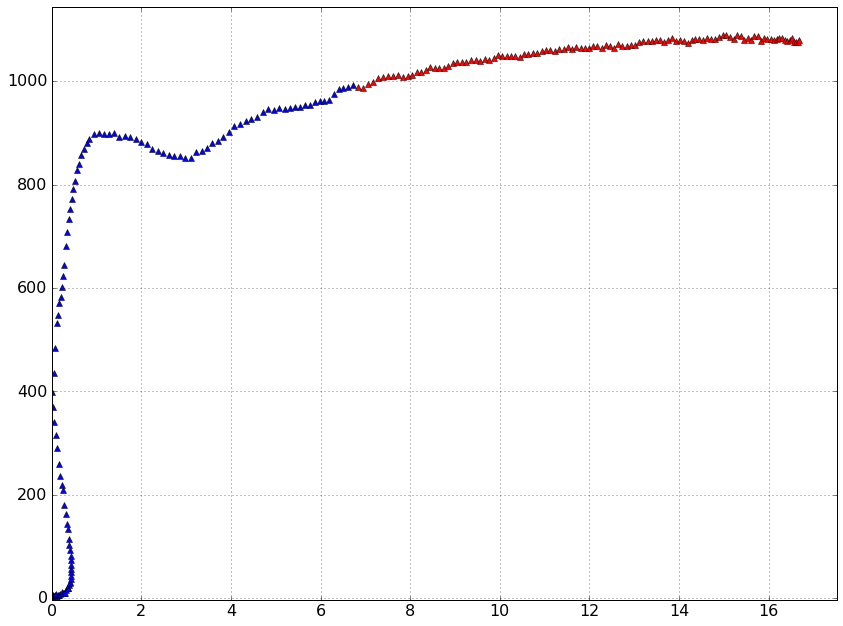

In [3]:
predictions = suite.kcluster(strainvslope, numclusters=2, init='random').predict(strain[:,None][:])
elastic, plastic = suite.splitdata(model,predictions)

plot.plotmult2D(elastic,plastic)

## This seems erroneous so let's look at the slopes that it believes are part of the same group

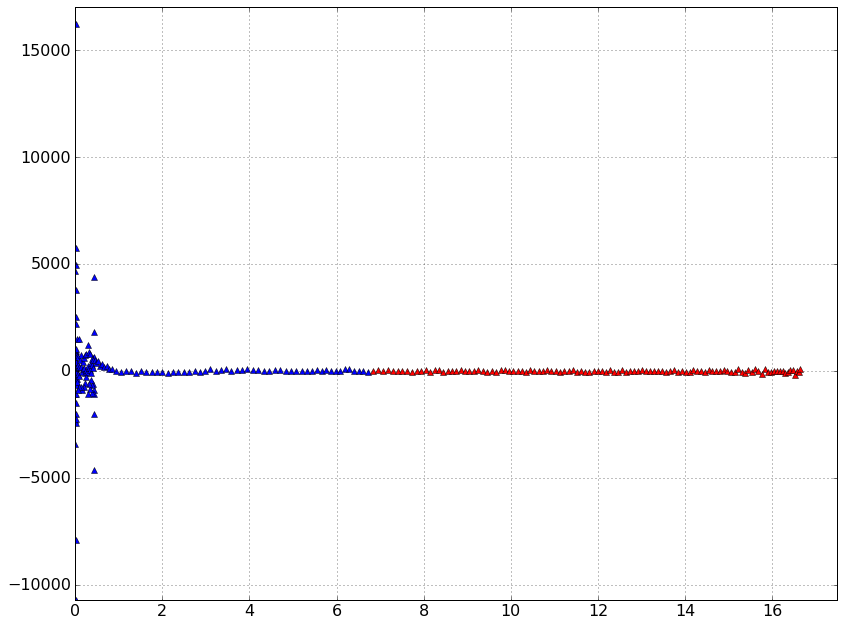

In [4]:
elastic_slope, plastic_slope = suite.splitdata(strainvslope, predictions)
plot.plotmult2D(elastic_slope,plastic_slope)

## Once the data slope begins decreasing, if we are far enough along we can say with confidence that yield is beginning

In [5]:
standard_deviation = np.std(slopes[:len(slopes)/4])
print standard_deviation

3122.09226699


In [6]:
yield_spot = 0

for index, slope in enumerate(slopes):
    
    if slope<-20 and index>(len(slopes)/4.):
        if slopes[index+1]<-20:
            yield_spot=index
            break
        
#print strain[yield_spot],stress[yield_spot]
#print slopes      

In [49]:
# -- this value needs to be high enough to get a good value, but low enough to avoid noisy data
num_intervals = 10

# -- divide into ten intervals and print stddev of each
divs = [np.std(vals) for vals in np.array_split(slopes,num_intervals)]

# -- stdev of the whole thing
stdev = np.std(slopes)

interval = 0
while divs[interval] > stdev:
    interval = interval + 1
    
# -- selects a point halfway in the interval
interval_length = len(model)/num_intervals
yield_index = ((int)(interval_length*interval*3./2.))

    
# -- found yield strain (ONLY TENTATIVELY WORKS -- REFINE THIS)
yield_strain = strain[yield_index]
yield_stress = stress[yield_index]

print divs

[4612.0882992710231, 426.06206684630507, 1515.1298640895604, 421.87182234860603, 48.777293699237568, 33.870484894562971, 28.784670818335488, 33.270855805159862, 31.012422403782136, 64.63547777934707]


[ 0.08134057  6.82299987]


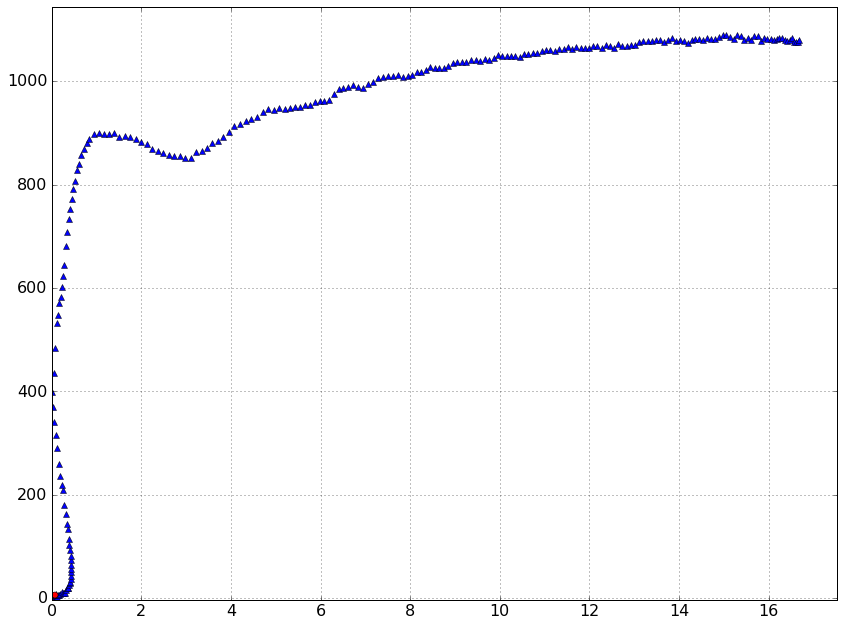

In [50]:
yielding = np.array([yield_strain,yield_stress])
print yielding

plot.plotmult2D(model,yielding[None,:],marker2='ro')

## The model is still highly subject to fluctuations from the number of intervals, and we need to select a place where the slope is negative mostly throughout the interval, and the standard deviation begins to decrease

In [131]:
# -- we think that yield occurs where the standard deviation is decreasing AND the slopes are mostly negative
def findYieldInterval(slopes, numberofsections):
    
    def numneg(val):
        return sum((val>0).astype(int))
    
    # -- divide into ten intervals and save stddev of each
    splitslopes = np.array_split(slopes,numberofsections)
      
    # -- displays the number of negative values in a range
    for section in splitslopes:
        print numneg(section), len(section)

    divs = [np.std(vals) for vals in splitslopes]
    
    # -- stddev of the whole thing
    stdev = np.std(slopes)
    
    interval = 0
    sect = splitslopes[interval]
    
    while divs[interval] > stdev or numneg(sect)<3*len(sect)/4:
        
        interval = interval + 1
        
        """Guard against going out of bounds"""
        if interval==len(splitslopes): break
            
        sect = splitslopes[interval]                                         
    
    return interval

numberofsections = 15
interval_length = len(model)/numberofsections

"""Middle of selected interval"""
yield_index = findYieldInterval(slopes,numberofsections)*interval_length*3/2 
yield_value = np.array([strain[yield_index],stress[yield_index]])[None,:]

print yield_value

9 18
9 18
12 18
5 18
12 18
15 18
7 17
14 17
15 17
11 17
9 17
7 17
12 17
9 17
8 17
[[   4.07692608  913.50878055]]


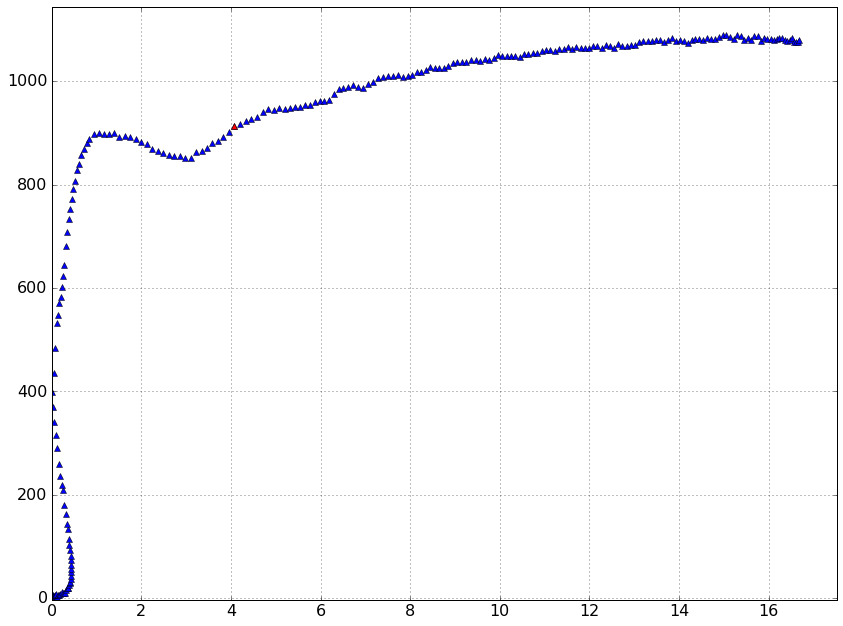

In [132]:
plot.plotmult2D(model,yield_value)

## Now we need to create a function that automatically determines the slopes from the data, calls the other function, and returns the appropriate values

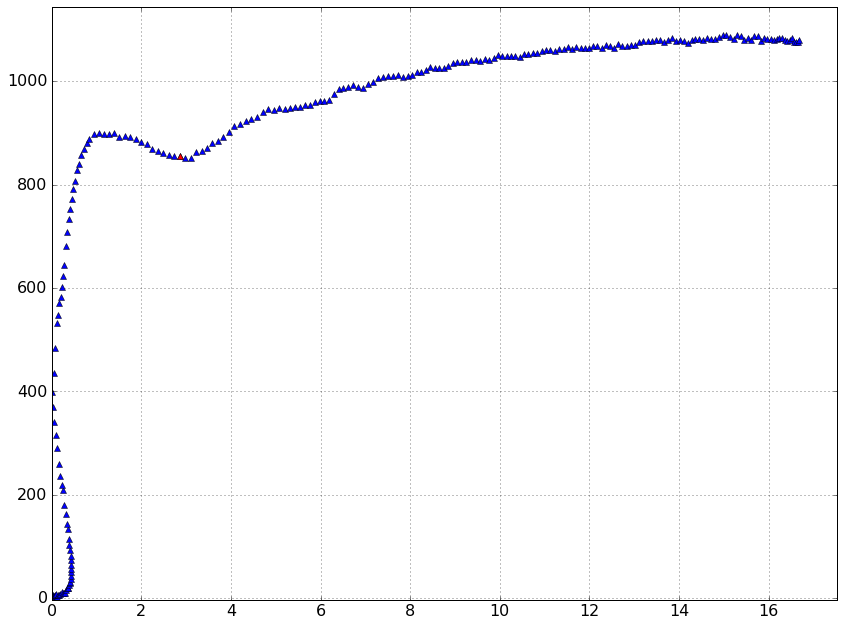

/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in double_scalars
/site/x86/anaconda-1.8/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


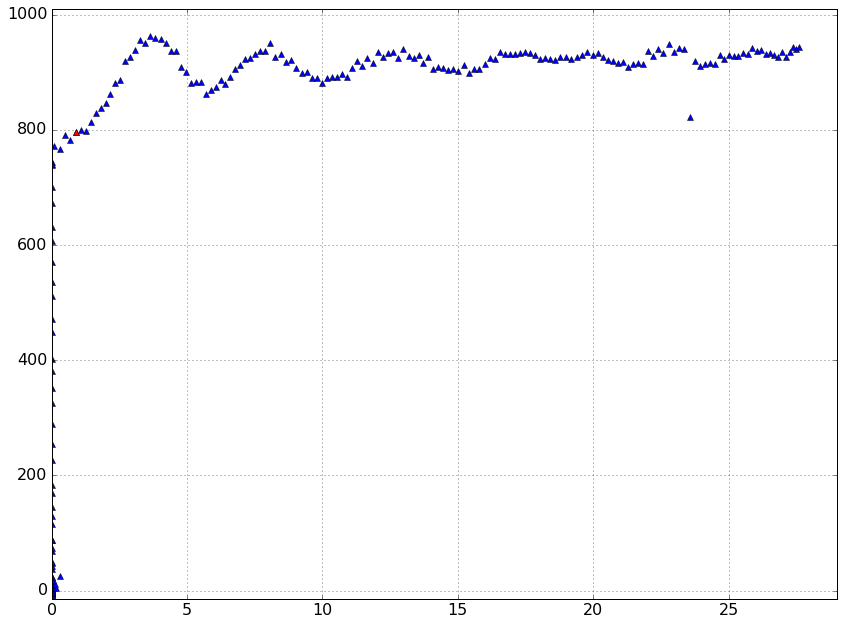

In [144]:
"""Yield occurs where the standard deviation is decreasing AND the slopes are mostly negative"""
def findYieldInterval(slopes, numberofsections):
    
    def numneg(val):
        return sum((val>0).astype(int))
    
    """Divide into ten intervals and save stddev of each"""
    splitslopes = np.array_split(slopes,numberofsections)
    divs = [np.std(vals) for vals in splitslopes]
    
    """Computes the reference standard deviation"""
    stdev = np.std(slopes)
    
    interval = 0
    sect = splitslopes[interval]
    
    while divs[interval] > stdev or numneg(sect)<3*len(sect)/4:
        
        interval = interval + 1
        
        """Guard against going out of bounds"""
        if interval==len(splitslopes): break
            
        sect = splitslopes[interval]                                         
    
    return interval

"""Returns yield value from a set of experimental data"""
def findYieldValue(model):
    
    """Separate appropriate values"""
    strain = model[:,0]
    stress = model[:,1]
    slopes = []

    """Approximating the partial derivatives of stress/strain"""
    for index in xrange(len(stress)-1):
        slopes.append((stress[index+1]-stress[index])/(strain[index+1]-strain[index]))
        
    """How many sections to create, depends on noisiness and courseness of data"""
    numberofsections = 10
    interval_length = len(model)/numberofsections
        
    """Middle of selected interval"""
    yield_index = findYieldInterval(slopes,numberofsections)*interval_length*3/2 
    yield_value = np.array([strain[yield_index],stress[yield_index]])[None,:]
    
    return yield_value

"""Plots data with superimposed yield value"""
def plotYieldValue(model):
    
    import graph_suite
    graph_suite.plotmult2D(model,findYieldValue(model))

model1 = strainmodel('ref/HSRS/22').get_experimental_data()
model2 = strainmodel('ref/HSRS/222').get_experimental_data()
model3 = strainmodel('ref/HSRS/326').get_experimental_data()

plotYieldValue(model1)
plotYieldValue(model3)